<a href="https://colab.research.google.com/github/shanikairoshi/DeepUnfolding-based-FL/blob/main/AdaptiveWeightDecay_onlyfor_DeepUnfolding_Code_Env4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set parameters
Download done
Set local data
Network defined
Model sharing done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Deep unfolding done
Learned theta:  tensor([[5.7258e-18, 2.4581e-19, 2.2739e-03, 6.1961e-03, 9.9153e-01],
        [6.3933e-29, 4.0989e-18, 9.9510e-07, 2.9539e-01, 7.0461e-01],
        [4.7252e-24, 7.8483e-24, 1.1998e-07, 1.1137e-04, 9.9989e-01],
        [3.2092e-27, 2.4062e-23, 2.6397e-08, 2.3812e-02, 9.7619e-01],
        [8.0558e-15, 1.2921e-15, 1.6072e-03, 5.5975e-02, 9.4242e-01],
        [2.5664e-11, 2.8940e-11, 1.1829e-02, 1.5737e-01, 8.3080e-01],
        [3.3904e-07, 7.3510e-06, 2.4084e-01, 1.3467e-01, 6.2449e-01],
        [4.7394e-05, 4.2817e-04, 2.7866e-01, 2.8376e-01, 4.3710e-01],
        [4.5428e-03, 1.0925e-02, 2.4393e-01, 3.2981e-01, 4.1079e-01],
        [7.6088e-02, 9.8288e-02, 2.2795e-01, 2.9322e-01, 3.0445e-01]])
DUW-FedAvg done
DUW-FedAvg loss =  [158.601

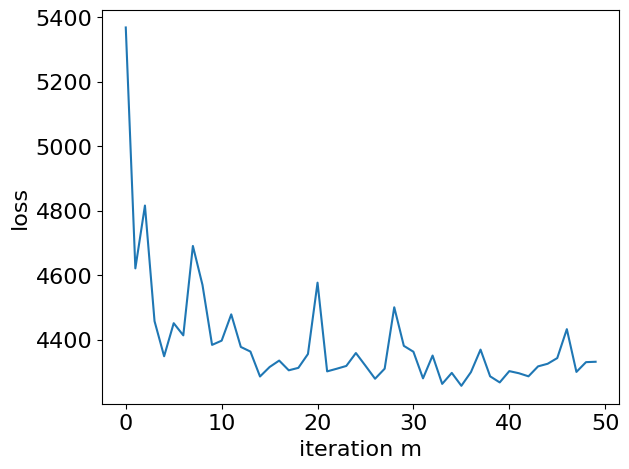

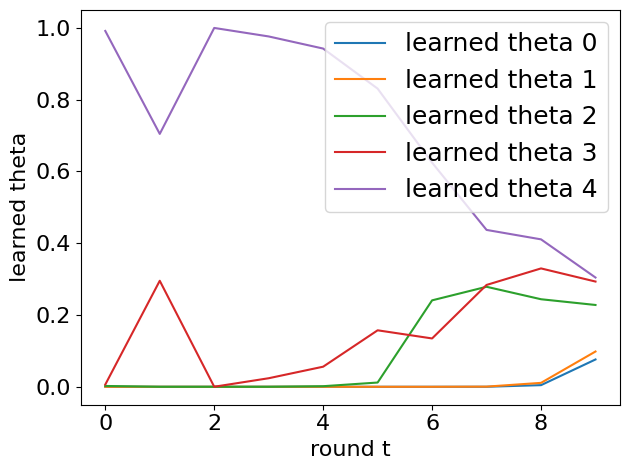

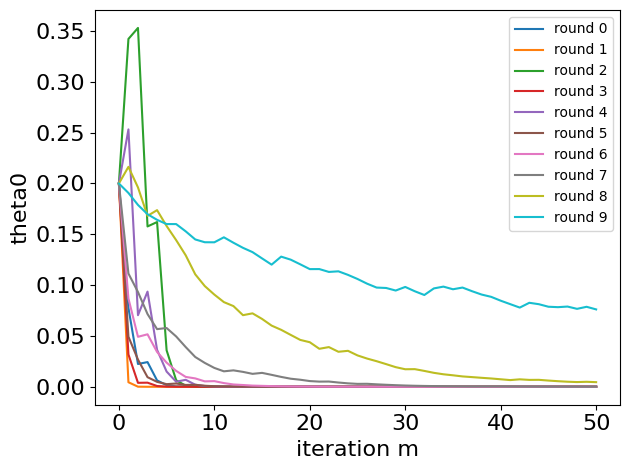

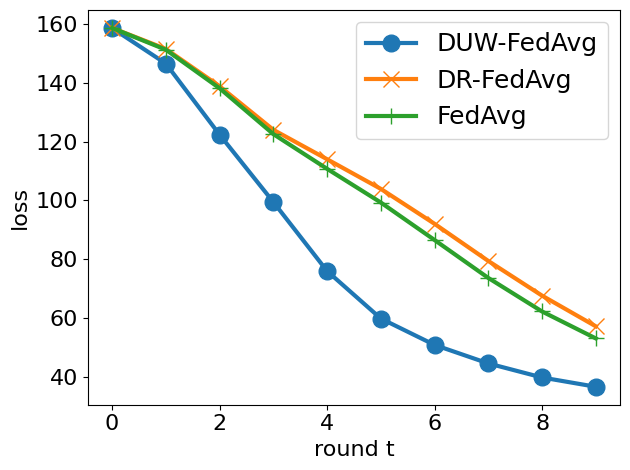

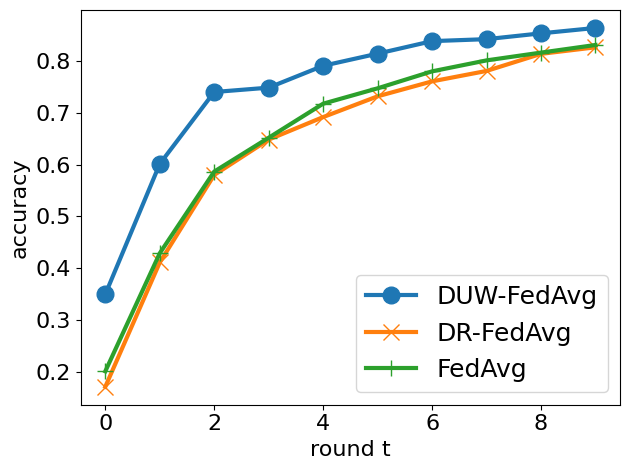

In [8]:
#%%
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#%% Parameters
T = 10                  # number of rounds for FL
M = 50                 # number of learning iterations
Es = [2, 2, 2, 2, 2]    # number of epochs
batch_size = 50         # mini-batch size
lr_du = 0.001           # learning rate for proposed preprocess
mu = 0.01               # learning rate for ClientUpdate
num_feature = 128       # dimension of hidden layers
q = 1                   # parameter for DR-FedAvg
com_prob = [0.2, 0.3, 0.8, 0.9, 1]  # communication probability

# Fixed parameters
K = 5                   # number of clients
datalocation = '/content/drive/MyDrive/ColabNotebooks/DeepUnfoldingFL/mnist/5clients_env3_4/'                     # data for env4
N = sum([1713, 1713, 1713, 1713, 1716])                     # number of all training data for env4

print("Set parameters", flush=True)

#%% Global Data Load
root = '.'
download = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=download)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

print("Download done", flush=True)

#%% Local Data
datasizes_test = []
for i in range(K):
    datasizes_test.append(int(round(len(test_set)/K)))
test_sets = torch.utils.data.random_split(dataset=test_set, lengths=datasizes_test, generator=torch.Generator().manual_seed(42))

test_loaders = []
train_datasets = []

for node in range (K):
    localtraindata = np.load(datalocation+'train/'+str(node)+'.npz', allow_pickle=True)     # training data load
    localtraindata = np.atleast_1d(localtraindata['data'])
    inputs = localtraindata[0]['x']
    targets = localtraindata[0]['y']
    tensor_X = torch.stack([torch.from_numpy(i) for i in inputs])
    tensor_y = torch.stack([torch.from_numpy(np.array(i)) for i in targets])
    train_datasets.append(torch.utils.data.TensorDataset(tensor_X,tensor_y))
    test_loaders.append(torch.utils.data.DataLoader(dataset=test_sets[node], batch_size=batch_size, shuffle=False))
pk = [len(train_datasets[node])/N for node in range(K)]

print("Set local data", flush=True)


#%% Definition of Initial Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, num_feature)
        self.l2 = nn.Linear(num_feature, num_feature)
        self.l3 = nn.Linear(num_feature, 10)
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return F.log_softmax(x, dim=1)


#%% Definition of Unfolded FL
class TrainDUW(nn.Module):
    def __init__(self) -> None:
        super(TrainDUW, self).__init__()
        self.thetak = nn.ParameterList([nn.Parameter(torch.ones(T)*np.sqrt(len(train_datasets[i])/N)) for i in range(K)])
        # initial value: N_k/N
    def network(self, W1, b1, W2, b2, W3, b3, x):
        x = torch.relu(torch.matmul(x,W1.T)+b1.T)
        x = torch.relu(torch.matmul(x,W2.T)+b2.T)
        x = F.log_softmax(torch.matmul(x,W3.T)+b3.T, dim=1)
        return x
    def forward(self, aveW1, aveb1, aveW2, aveb2, aveW3, aveb3):
        outputlists = []
        targetlists = []
        for itr in range(T+1):
            tmploss = 0.
            outputlist = []
            targetlist = []
            iscom = torch.bernoulli(torch.Tensor(com_prob))
            if not itr == T:
                sumweights = sum([self.thetak[x][itr]**2 for x in range(K)])
            for node in range(K):
                weight1, bias1, weight2, bias2, weight3, bias3 = aveW1, aveb1, aveW2, aveb2, aveW3, aveb3
                weight1.requires_grad_(True)
                bias1.requires_grad_(True)
                weight2.requires_grad_(True)
                bias2.requires_grad_(True)
                weight3.requires_grad_(True)
                bias3.requires_grad_(True)
                train_loader_node = torch.utils.data.DataLoader(dataset=train_datasets[node], batch_size=batch_size, shuffle=True)
                outputvalues = []
                targetvalues = []
                for ep in range(Es[node]):
                    for (input, target) in train_loader_node:
                        input = input.view(-1, 28*28)
                        output = self.network(weight1,bias1,weight2,bias2,weight3,bias3,input)
                        outputvalues.append(output)
                        targetvalues.append(target)
                        if int(iscom[node]):
                            if not itr == T:
                                loss = F.nll_loss(output, target)
                                tmploss += loss.item()
                                w1grad = torch.autograd.grad(loss,weight1,retain_graph=True)
                                b1grad = torch.autograd.grad(loss,bias1,retain_graph=True)
                                w2grad = torch.autograd.grad(loss,weight2,retain_graph=True)
                                b2grad = torch.autograd.grad(loss,bias2,retain_graph=True)
                                w3grad = torch.autograd.grad(loss,weight3,retain_graph=True)
                                b3grad = torch.autograd.grad(loss,bias3,retain_graph=True)
                                weight1 = weight1 - mu * w1grad[0].detach()
                                bias1 = bias1 - mu * b1grad[0].detach()
                                weight2 = weight2 - mu * w2grad[0].detach()
                                bias2 = bias2 - mu * b2grad[0].detach()
                                weight3 = weight3 - mu * w3grad[0].detach()
                                bias3 = bias3 - mu * b3grad[0].detach()
                if not itr == T:
                    if node == 0:
                        weight0 = self.thetak[node][itr]**2 / sumweights
                        W1, b1, W2, b2, W3, b3 = weight1*weight0, bias1*weight0, weight2*weight0, bias2*weight0, weight3*weight0, bias3*weight0
                    else:
                        weightnode = self.thetak[node][itr]**2 / sumweights
                        W1, b1, W2, b2, W3, b3 = W1 + weight1*weightnode, b1 + bias1*weightnode, W2 + weight2*weightnode, b2 + bias2*weightnode, W3 + weight3*weightnode, b3 + bias3*weightnode
                outputlist.append(outputvalues)
                targetlist.append(targetvalues)
            aveW1, aveb1, aveW2, aveb2, aveW3, aveb3 = W1, b1, W2, b2, W3, b3
            outputlists.append(outputlist)
            targetlists.append(targetlist)
        return outputlists, targetlists

print("Network defined", flush=True)


#%% Functions
def model_initialize(initmodel):
    models = []
    for i in range(K):
        models.append(Net())
    for node in range(K):
        models[node].l1.weight.data = initmodel.l1.weight.data.clone()
        models[node].l1.bias.data = initmodel.l1.bias.data.clone()
        models[node].l2.weight.data = initmodel.l2.weight.data.clone()
        models[node].l2.bias.data = initmodel.l2.bias.data.clone()
        models[node].l3.weight.data = initmodel.l3.weight.data.clone()
        models[node].l3.bias.data = initmodel.l3.bias.data.clone()
    return models


def testscalar(dataloaders,model):
    correct = [0 for _ in range(K)] # Initialize a list for each node's accuracy
    count = [0 for _ in range(K)]
    with torch.no_grad():
        for node in range(K):
            for (input, target) in dataloaders[node]:
                input = input.view(-1, 28*28)
                output = models[node](input)
                pred = output.argmax(dim=1)
                correct[node] += pred.eq(target.data).sum() # Update correct count for current node
                count[node] += input.size()[0] # Update count for current node
    return [float(c)/float(n) for c, n in zip(correct, count)] # Return a list of accuracies



def train(datasets,model,optimizer,loop,method,modelfortheta,iscom):
    running_loss = 0.0
    if method=='dr':
        Fk = [0. for _ in range(K)]
    for node in range(K):
        train_loader_node = torch.utils.data.DataLoader(dataset=datasets[node], batch_size=batch_size, shuffle=True)
        for ep in range(Es[node]):
            for (input, target) in train_loader_node:
                input = input.view(-1, 28*28)
                optimizer[node].zero_grad()
                output = model[node](input)
                loss = F.nll_loss(output, target)
                if int(iscom[loop][node]):
                    loss.backward()
                    optimizer[node].step()
                running_loss += loss.item()
                if method=='dr':
                    Fk[node] += loss.item()

    # Compute accuracies for scaling factors
    accuracies = [testscalar(test_loaders, model)[node] for node in range(K)] # Calculate scaling factors
    total_accuracy = sum(accuracies)
    if total_accuracy > 0:
        scaling_factors = [accuracy / total_accuracy for accuracy in accuracies]
    else:
        scaling_factors = [1.0 / K for _ in range(K)]  # Fallback to equal scaling

    # aggregation
    with torch.no_grad():
        if method=='du':
            sumweights = sum([modelfortheta.thetak[x][loop].item()**2 for x in range(K)])
        elif method=='dr':
            sumpkFk = sum([pk[node]*(Fk[node]**(q+1)) for node in range(K)])
        ps_global = []

        for params in range(len(list(model[0].parameters()))):
            if method=='du':
                ps_global.append(list(model[0].parameters())[params].data * (modelfortheta.thetak[0][loop].data.item()**2 / sumweights)*scaling_factors[node])
            elif method=='origin':
                ps_global.append(list(model[0].parameters())[params].data*len(train_datasets[0])/N)
            elif method=='dr':
                ps_global.append(list(model[0].parameters())[params].data*pk[0]*(Fk[0]**(q+1))/sumpkFk)
            for node in range(1,K):
                if method=='du':
                    ps_global[params] += list(model[node].parameters())[params].data * modelfortheta.thetak[node][loop].data.item()**2 / sumweights
                elif method=='origin':
                    ps_global[params] += list(model[node].parameters())[params].data*len(train_datasets[node])/N
                elif method=='dr':
                    ps_global[params] += list(model[node].parameters())[params].data*pk[node]*(Fk[node]**(q+1))/sumpkFk
        # parameter sharing
        for node in range(K):
            model[node].l1.weight.data = ps_global[0].clone()
            model[node].l1.bias.data = ps_global[1].clone()
            model[node].l2.weight.data = ps_global[2].clone()
            model[node].l2.bias.data = ps_global[3].clone()
            model[node].l3.weight.data = ps_global[4].clone()
            model[node].l3.bias.data = ps_global[5].clone()
    return running_loss/K

def test(dataloaders,model):
    correct =  0
    count = 0
    with torch.no_grad():
        for node in range(K):
            for (input, target) in dataloaders[node]:
                input = input.view(-1, 28*28)
                output = model[node](input)
                pred = output.argmax(dim=1)
                correct += pred.eq(target.data).sum()
                count += input.size()[0]
    return float(correct)/float(count)


#%% Model Sharing
model = Net()       # common initial model
models = model_initialize(model)        # models for proposed DUW-FedAvg
models2 = model_initialize(model)       # models for original FedAvg
models3 = model_initialize(model)       # models for DR-FedAvg


# initial model parameters
aveW1 = model.l1.weight.data.clone().requires_grad_(False)
aveb1 = model.l1.bias.data.clone().requires_grad_(False)
aveW2 = model.l2.weight.data.clone().requires_grad_(False)
aveb2 = model.l2.bias.data.clone().requires_grad_(False)
aveW3 = model.l3.weight.data.clone().requires_grad_(False)
aveb3 = model.l3.bias.data.clone().requires_grad_(False)

print("Model sharing done", flush=True)


#%%
modelDU = TrainDUW()
learnedweights = torch.zeros(M+1, T, K)
sumweights = torch.zeros(T)
for itr in range(T):
    sumweights[itr] = sum([modelDU.thetak[x][itr].item()**2 for x in range(K)])
for node in range(K):
    learnedweights[0,:,node] = modelDU.thetak[node].detach()**2 / sumweights
optimizerDU = optim.SGD(modelDU.parameters(), lr=lr_du)

#%%

def calculate_node_accuracies(models, dataloaders):
        # Compute accuracies for scaling factors
    accuracies = [testscalar(test_loaders, model)[node] for node in range(K)] # Calculate scaling factors
    return accuracies

def normalize_scaling_factors(accuracies):
    total_accuracy = sum(accuracies)
    if total_accuracy > 0:
        scaling_factors = [accuracy / total_accuracy for accuracy in accuracies]
    else:
        scaling_factors = [1.0 / K for _ in range(K)]  # Fallback to equal scaling
    #normalized_scaling_factors = [acc / total_accuracy for acc in accuracies]
    return scaling_factors

# Training of Deep Unfolding-based Weights
initial_weight_decay = 1e-4  # Base weight decay value
outerloss = []
i = 0
for loop in range(M):
    i = i+1
    print(i, flush=True)
    optimizerDU.zero_grad()
    outputlists, targetlists = modelDU(aveW1, aveb1, aveW2, aveb2, aveW3, aveb3)
    loss = 0
    for j in range(T+1):
        for node in range(K):

            num_localdata = len(outputlists[j][node])
            for l in range(num_localdata):
                loss += F.nll_loss(outputlists[j][node][l], targetlists[j][node][l])

    # Calculate node accuracies after each loop (or after every few loops)
    accuracies = calculate_node_accuracies(models, test_loaders)

    # Normalize accuracies to use as scaling factors
    scaling_factors = normalize_scaling_factors(accuracies)

    # Apply accuracy-scaled weight decay
    with torch.no_grad():
        for node in range(K):
            current_weight_decay = initial_weight_decay * scaling_factors[node]

            for param in modelDU.parameters():
                if param.grad is not None:
                    # Applying the weight decay using accuracy-scaled factor
                    param.data -= current_weight_decay * param.data

    loss.backward()
    optimizerDU.step()
    outerloss.append(loss.item())
    sumweights = torch.zeros(T)
    for itr in range(T):
        sumweights[itr] = sum([modelDU.thetak[x][itr].item()**2 for x in range(K)])
    for node in range(K):
        learnedweights[i,:,node] = modelDU.thetak[node].detach()**2 / sumweights

print("Deep unfolding done", flush=True)
# print ('outerloss = ', outerloss, flush=True)

#%% Figures
# loss during deep unfolding
fig = plt.figure()
plt.plot(outerloss)
plt.xlabel("iteration m", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
fig.savefig("outerloss_du.png")

# learned thetak
fig2 = plt.figure()
for node in range(K):
    labelname = 'learned theta ' + str(node)
    plt.plot([i for i in learnedweights[M,:,node]], label=labelname)
plt.legend(fontsize=18)
plt.xlabel("round t", fontsize=16)
plt.ylabel("learned theta", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
fig2.savefig("learned_thetak.png")
print('Learned theta: ', learnedweights[M,:,:], flush=True)

# trajectory of weight during deep unfolding
fig3 = plt.figure()
for itr in range(T):
    labelname = 'round ' + str(itr)
    plt.plot([i for i in learnedweights[:,itr,0]], label=labelname)     # trajectory of client 0's weight for each round
plt.legend()
plt.xlabel("iteration m", fontsize=16)
plt.ylabel("theta0", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
fig3.savefig("theta0.png")


#%% Federated Learning
iscom = [torch.bernoulli(torch.Tensor(com_prob)) for i in range(T)]

# DUW-FedAvg
optimizers = []
for i in range(K):
    optimizers.append(optim.SGD(models[i].parameters(), lr=mu))
fl_loss = []
fl_acc = []
for loop in range(T):
    loss = train(train_datasets,models,optimizers,loop,'du',modelDU,iscom)
    fl_loss.append(loss)
    acc = test(test_loaders,models)
    fl_acc.append(acc)

print("DUW-FedAvg done", flush=True)
print ('DUW-FedAvg loss = ', fl_loss, flush=True)
print ('DUW-FedAvg acc = ', fl_acc, flush=True)

#%%
# original FedAvg
optimizers2 = []
for i in range(K):
    optimizers2.append(optim.SGD(models2[i].parameters(), lr=mu))
fl2_loss = []
fl2_acc = []
for loop in range(T):
    loss = train(train_datasets,models2,optimizers2,loop,'origin',modelDU,iscom)
    fl2_loss.append(loss)
    acc = test(test_loaders,models2)
    fl2_acc.append(acc)

print("original FedAvg done", flush=True)
print ('original FedAvg loss = ', fl2_loss, flush=True)
print ('original FedAvg acc = ', fl2_acc, flush=True)

#%%
# DR-FedAvg
optimizers3 = []
for i in range(K):
    optimizers3.append(optim.SGD(models3[i].parameters(), lr=mu))

# learning
fl3_loss = []
fl3_acc = []
for loop in range(T):
    loss = train(train_datasets,models3,optimizers3,loop,'dr',modelDU,iscom)
    fl3_loss.append(loss)
    acc = test(test_loaders,models3)
    fl3_acc.append(acc)

print("DR-FedAvg done", flush=True)
print ('DR-FedAvg loss = ', fl3_loss, flush=True)
print ('DR-FedAvg acc = ', fl3_acc, flush=True)


#%%
plt.figure()
plt.plot(fl_loss, linewidth=3, marker="o", markersize=12, label="DUW-FedAvg")
plt.plot(fl3_loss, linewidth=3, marker="x", markersize=12, label="DR-FedAvg")
plt.plot(fl2_loss, linewidth=3, marker="+", markersize=12, label="FedAvg")
plt.legend(fontsize=18)
plt.xlabel("round t", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("flloss.png")

#%%
plt.figure()
plt.plot(fl_acc, linewidth=3, marker="o", markersize=12, label="DUW-FedAvg")
plt.plot(fl3_acc, linewidth=3, marker="x", markersize=12, label="DR-FedAvg")
plt.plot(fl2_acc, linewidth=3, marker="+", markersize=12, label="FedAvg")
plt.legend(fontsize=18)
plt.xlabel("round t", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("flacc.png")

In [ ]:
def train(datasets,model,optimizer,loop,method,modelfortheta,iscom):
    running_loss = 0.0
    if method=='dr':
        Fk = [0. for _ in range(K)]
    for node in range(K):
        train_loader_node = torch.utils.data.DataLoader(dataset=datasets[node], batch_size=batch_size, shuffle=True)
        for ep in range(Es[node]):
            for (input, target) in train_loader_node:
                input = input.view(-1, 28*28)
                optimizer[node].zero_grad()
                output = model[node](input)
                loss = F.nll_loss(output, target)
                if int(iscom[loop][node]):
                    loss.backward()
                    optimizer[node].step()
                running_loss += loss.item()
                if method=='dr':
                    Fk[node] += loss.item()

    # Compute accuracies for scaling factors
    accuracies = [testscalar(test_loaders, model)[node] for node in range(K)] # Calculate scaling factors
    total_accuracy = sum(accuracies)
    if total_accuracy > 0:
        scaling_factors = [accuracy / total_accuracy for accuracy in accuracies]
    else:
        scaling_factors = [1.0 / K for _ in range(K)]  # Fallback to equal scaling

    # aggregation
    with torch.no_grad():
        if method=='du':
            sumweights = sum([modelfortheta.thetak[x][loop].item()**2 for x in range(K)])
        elif method=='dr':
            sumpkFk = sum([pk[node]*(Fk[node]**(q+1)) for node in range(K)])
        ps_global = []

        for params in range(len(list(model[0].parameters()))):
            if method=='du':
                ps_global.append(list(model[0].parameters())[params].data * (modelfortheta.thetak[0][loop].data.item()**2 / sumweights)*scaling_factors[node])
            elif method=='origin':
                ps_global.append(list(model[0].parameters())[params].data*len(train_datasets[0])/N)
            elif method=='dr':
                ps_global.append(list(model[0].parameters())[params].data*pk[0]*(Fk[0]**(q+1))/sumpkFk)
            for node in range(1,K):
                if method=='du':
                    ps_global[params] += list(model[node].parameters())[params].data * modelfortheta.thetak[node][loop].data.item()**2 / sumweights
                elif method=='origin':
                    ps_global[params] += list(model[node].parameters())[params].data*len(train_datasets[node])/N
                elif method=='dr':
                    ps_global[params] += list(model[node].parameters())[params].data*pk[node]*(Fk[node]**(q+1))/sumpkFk
        # parameter sharing
        for node in range(K):
            model[node].l1.weight.data = ps_global[0].clone()
            model[node].l1.bias.data = ps_global[1].clone()
            model[node].l2.weight.data = ps_global[2].clone()
            model[node].l2.bias.data = ps_global[3].clone()
            model[node].l3.weight.data = ps_global[4].clone()
            model[node].l3.bias.data = ps_global[5].clone()
    return running_loss/K

def test(dataloaders,model):
    correct =  0
    count = 0
    with torch.no_grad():
        for node in range(K):
            for (input, target) in dataloaders[node]:
                input = input.view(-1, 28*28)
                output = model[node](input)
                pred = output.argmax(dim=1)
                correct += pred.eq(target.data).sum()
                count += input.size()[0]
    return float(correct)/float(count)


#%% Model Sharing
model = Net()       # common initial model
models = model_initialize(model)        # models for proposed DUW-FedAvg
models2 = model_initialize(model)       # models for original FedAvg
models3 = model_initialize(model)       # models for DR-FedAvg

# initial model parameters
aveW1 = model.l1.weight.data.clone().requires_grad_(False)
aveb1 = model.l1.bias.data.clone().requires_grad_(False)
aveW2 = model.l2.weight.data.clone().requires_grad_(False)
aveb2 = model.l2.bias.data.clone().requires_grad_(False)
aveW3 = model.l3.weight.data.clone().requires_grad_(False)
aveb3 = model.l3.bias.data.clone().requires_grad_(False)

print("Model sharing done", flush=True)


In [ ]:

#%% Federated Learning
iscom = [torch.bernoulli(torch.Tensor(com_prob)) for i in range(T)]

# DUW-FedAvg
optimizers = []
for i in range(K):
    optimizers.append(optim.SGD(models[i].parameters(), lr=mu))
fl_loss = []
fl_acc = []
for loop in range(T):
    loss = train(train_datasets,models,optimizers,loop,'du',modelDU,iscom)
    fl_loss.append(loss)
    acc = test(test_loaders,models)
    fl_acc.append(acc)

print("DUW-FedAvg done", flush=True)
print ('DUW-FedAvg loss = ', fl_loss, flush=True)
print ('DUW-FedAvg acc = ', fl_acc, flush=True)

In [ ]:
#%%
# original FedAvg
optimizers2 = []
for i in range(K):
    optimizers2.append(optim.SGD(models2[i].parameters(), lr=mu))
fl2_loss = []
fl2_acc = []
for loop in range(T):
    loss = train(train_datasets,models2,optimizers2,loop,'origin',modelDU,iscom)
    fl2_loss.append(loss)
    acc = test(test_loaders,models2)
    fl2_acc.append(acc)

print("original FedAvg done", flush=True)
print ('original FedAvg loss = ', fl2_loss, flush=True)
print ('original FedAvg acc = ', fl2_acc, flush=True)

#%%
# DR-FedAvg
optimizers3 = []
for i in range(K):
    optimizers3.append(optim.SGD(models3[i].parameters(), lr=mu))

# learning
fl3_loss = []
fl3_acc = []
for loop in range(T):
    loss = train(train_datasets,models3,optimizers3,loop,'dr',modelDU,iscom)
    fl3_loss.append(loss)
    acc = test(test_loaders,models3)
    fl3_acc.append(acc)

print("DR-FedAvg done", flush=True)
print ('DR-FedAvg loss = ', fl3_loss, flush=True)
print ('DR-FedAvg acc = ', fl3_acc, flush=True)


#%%
plt.figure()
plt.plot(fl_loss, linewidth=3, marker="o", markersize=12, label="DUW-FedAvg")
plt.plot(fl3_loss, linewidth=3, marker="x", markersize=12, label="DR-FedAvg")
plt.plot(fl2_loss, linewidth=3, marker="+", markersize=12, label="FedAvg")
plt.legend(fontsize=18)
plt.xlabel("round t", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("flloss.png")

#%%
plt.figure()
plt.plot(fl_acc, linewidth=3, marker="o", markersize=12, label="DUW-FedAvg")
plt.plot(fl3_acc, linewidth=3, marker="x", markersize=12, label="DR-FedAvg")
plt.plot(fl2_acc, linewidth=3, marker="+", markersize=12, label="FedAvg")
plt.legend(fontsize=18)
plt.xlabel("round t", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("flacc.png")

In [ ]:
print(fl_acc)#duw
print(fl2_acc)#FedAvg
print(fl3_acc)#dr

In [7]:
import csv
# Saving results of default DeepUnfolding FL to a CSV file
filename = "AdaptiveWeightDecay_onlyfor_DeepUnfolding_Code_Env4s.csv"

# Creating a list of dictionaries for each result entry
results = []
for i in range(len(fl_loss)):
    result = {
        'Iteration': i + 1,
        'Loss': fl_loss[i],
        'Accuracy': fl_acc[i]
    }
    results.append(result)

# Writing the results to the CSV file
keys = ['Iteration', 'Loss', 'Accuracy']

with open(filename, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)

print(f'Deep Unfolding Fl default Results saved to {filename}')
#%%
#=============================================================


# Saving FedAvg results to a CSV file
filename = "defaultresultsEnv4_FedAvg.csv"

# Creating a list of dictionaries for each result entry
results = []
for i in range(len(fl2_loss)):
    result = {
        'Iteration': i + 1,
        'Loss': fl2_loss[i],
        'Accuracy': fl2_acc[i]
    }
    results.append(result)

# Writing the results to the CSV file
keys = ['Iteration', 'Loss', 'Accuracy']

with open(filename, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)

print(f'Results saved to {filename}')

#===================================================

# Saving DR results to a CSV file
filename = "defaultresultsEnv4_DR.csv"

# Creating a list of dictionaries for each result entry
results = []
for i in range(len(fl3_loss)):
    result = {
        'Iteration': i + 1,
        'Loss': fl3_loss[i],
        'Accuracy': fl3_acc[i]
    }
    results.append(result)

# Writing the results to the CSV file
keys = ['Iteration', 'Loss', 'Accuracy']

with open(filename, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)

print(f'Results saved to {filename}')

Deep Unfolding Fl default Results saved to AdaptiveWeightDecay_onlyfor_DeepUnfolding_Code_Env4s.csv
Results saved to defaultresultsEnv4_FedAvg.csv
Results saved to defaultresultsEnv4_DR.csv


Read Results and draw graphs



In [ ]:
#code for environment 01
import matplotlib.pyplot as plt
import csv
# Define the file path
filename = "defaultresultsEnv4_FedAvg.csv"

# Create empty lists to store the data
iterations = []
Default_FedAvgloss = []
Default_FedAvgacc = []

# Read the CSV file
with open(filename, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        iterations.append(int(row['Iteration']))
        Default_FedAvgloss.append(float(row['Loss']))
        Default_FedAvgacc.append(float(row['Accuracy']))

# Print the retrieved data
#print("Iterations:", iterations)
print("FedAvgloss Losses:", Default_FedAvgloss)
print("FedAvgacc Accuracies:", Default_FedAvgacc)
#==================================
# Define the file path
filename = "WeightDecay_onlyfor_DeepUnfolding_Code_Env4s.csv"

# Create empty lists to store the data
iterations = []
Default_DUW_loss = []
Default_DUW_acc = []

# Read the CSV file
with open(filename, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        iterations.append(int(row['Iteration']))
        Default_DUW_loss.append(float(row['Loss']))
        Default_DUW_acc.append(float(row['Accuracy']))

# Print the retrieved data
#print("Iterations:", iterations)
print("Default_DUW_loss Losses:", Default_DUW_loss)
print("Default_DUW_acc Accuracies:", Default_DUW_acc)

#============================

# Define the file path
filename = "defaultresultsEnv4_DR.csv"

# Create empty lists to store the data
iterations = []
DR_loss = []
DR_acc = []

# Read the CSV file
with open(filename, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        iterations.append(int(row['Iteration']))
        DR_loss.append(float(row['Loss']))
        DR_acc.append(float(row['Accuracy']))

# Print the retrieved data
#print("Iterations:", iterations)
print("DR_loss Losses:", DR_loss)
print("DR_acc Accuracies:", DR_acc)

plt.figure()
plt.plot(Default_DUW_loss, linewidth=3, marker="o", markersize=12,color='orange', label="DUW")
plt.plot(Default_FedAvgloss, linewidth=3, marker="+", markersize=12,color='blue', label="FedAvg")
plt.plot(DR_loss, linewidth=3, marker="x", markersize=12,color='green', label="DR")
#plt.plot(originalFedAvgloss, linewidth=3, marker="+", markersize=12,color='red', label="FedAvg")
plt.legend(fontsize=18)
plt.xlabel("com_round t", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("Propsed_loss.png")

#%%
plt.figure()
plt.plot(Default_DUW_acc, linewidth=3, marker="o", markersize=12,color='orange', label="DUW")
plt.plot(Default_FedAvgacc, linewidth=3, marker="+", markersize=12,color='blue', label="FedAvg")

plt.plot(DR_acc, linewidth=3, marker="x", markersize=12,color='green', label="DR")
#plt.plot(originalFedAvgacc, linewidth=3, marker="+", markersize=12,color='red', label="FedAvg")
plt.legend(fontsize=18)
plt.xlabel("com_round t", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("Proposed_acc.png")